In [20]:
import pandas as pd

# Load the datasets
neighbourhoods_path = 'neighbourhoods.csv'
transit_stops_path = 'transit-gtfs-stops.csv'

# Reading the files
neighbourhoods_df = pd.read_csv(neighbourhoods_path)
transit_stops_df = pd.read_csv(transit_stops_path)

# Display the first few rows of each dataframe to understand their structure
(neighbourhoods_df.head(), transit_stops_df.head())


(                                           ﻿"NAME"  NEIGHBOURHOOD_ID  \
 0                                          Queen's                35   
 1                                       Reddendale                18   
 2                                   Marker's Acres                23   
 3                                     CFB Kingston                38   
 4  Elginburg / Silvers Corners / Shannon's Corners                 2   
 
                                              GeoJSON  \
 0  {"coordinates": [[[-76.490315, 44.2228171], [-...   
 1  {"coordinates": [[[-76.5419193, 44.2202127], [...   
 2  {"coordinates": [[[-76.4500252, 44.2803519], [...   
 3  {"coordinates": [[[-76.4161835, 44.2692478], [...   
 4  {"coordinates": [[[-76.4467212, 44.344177], [-...   
 
                              geo_point_2d  
 0   44.22844190948068, -76.49555375120859  
 1   44.21474180973019, -76.56198663382315  
 2  44.271478677735885, -76.47717293215645  
 3   44.24683088710861, -76.43698876

In [22]:
neighbourhoods_df.columns, transit_stops_df.columns


(Index(['﻿"NAME"', 'NEIGHBOURHOOD_ID', 'GeoJSON', 'geo_point_2d', 'Latitude',
        'Longitude', 'Distance_to_Nearest_Stop'],
       dtype='object'),
 Index(['ID', 'Code', 'Name', 'Coordinates', 'Description', 'Zone ID', 'URL',
        'Location Type', 'Parent Station ID', 'Timezone', 'Wheelchair Boarding',
        'Latitude', 'Longitude'],
       dtype='object'))

In [23]:
neighbourhoods_df = neighbourhoods_df.rename(columns={'\ufeff"NAME"': 'NAME'})


In [24]:
from geopy.distance import geodesic
import ast

# Extract coordinates from 'geo_point_2d' in neighbourhoods dataframe
neighbourhoods_df['Latitude'] = neighbourhoods_df['geo_point_2d'].apply(lambda x: float(x.split(', ')[0]))
neighbourhoods_df['Longitude'] = neighbourhoods_df['geo_point_2d'].apply(lambda x: float(x.split(', ')[1]))

# Extract coordinates from 'Coordinates' in transit stops dataframe
transit_stops_df['Latitude'] = transit_stops_df['Coordinates'].apply(lambda x: float(x.split(', ')[0]))
transit_stops_df['Longitude'] = transit_stops_df['Coordinates'].apply(lambda x: float(x.split(', ')[1]))

# Function to find the nearest transit stop for each neighbourhood and calculate the distance
def find_nearest_stop(neighbourhood_lat, neighbourhood_lon):
    distances = transit_stops_df.apply(
        lambda row: geodesic(
            (neighbourhood_lat, neighbourhood_lon), 
            (row['Latitude'], row['Longitude'])
        ).meters, 
        axis=1
    )
    return distances.min()

# Calculate the distance to the nearest bus stop for each neighbourhood
neighbourhoods_df['Distance_to_Nearest_Stop'] = neighbourhoods_df.apply(
    lambda row: find_nearest_stop(row['Latitude'], row['Longitude']), axis=1)

# Display the results
neighbourhoods_df[['NAME', 'Latitude', 'Longitude', 'Distance_to_Nearest_Stop']].head()


,NAME,Latitude,Longitude,Distance_to_Nearest_Stop
0,Queen's,44.228442,-76.495554,15.056346
1,Reddendale,44.214742,-76.561987,493.493330
2,Marker's Acres,44.271479,-76.477173,151.351574
3,CFB Kingston,44.246831,-76.436989,530.697900
4,Elginburg / Silvers Corners / Shannon's Corners,44.308167,-76.499480,3890.738839


In [25]:
# Define a function to categorize the accessibility based on distance to the nearest bus stop
def categorize_accessibility(distance):
    if distance <= 500:
        return 'Very Accessible (within 500 meters)'
    elif distance <= 1000:
        return 'Accessible (within 500 meters to 1 km)'
    elif distance <= 2000:
        return 'Moderately Accessible (within 1 km to 2 km)'
    else:
        return 'Poorly Accessible (more than 2 km)'

# Apply the categorization function to the neighbourhoods dataframe
neighbourhoods_df['Accessibility_Category'] = neighbourhoods_df['Distance_to_Nearest_Stop'].apply(categorize_accessibility)

# Calculate summary statistics for the categorization
category_counts = neighbourhoods_df['Accessibility_Category'].value_counts()
category_percentages = (category_counts / len(neighbourhoods_df)) * 100

# Display the counts and percentages of each category
category_counts, category_percentages


(Very Accessible (within 500 meters)            25
 Poorly Accessible (more than 2 km)              9
 Accessible (within 500 meters to 1 km)          7
 Moderately Accessible (within 1 km to 2 km)     4
 Name: Accessibility_Category, dtype: int64,
 Very Accessible (within 500 meters)            55.555556
 Poorly Accessible (more than 2 km)             20.000000
 Accessible (within 500 meters to 1 km)         15.555556
 Moderately Accessible (within 1 km to 2 km)     8.888889
 Name: Accessibility_Category, dtype: float64)

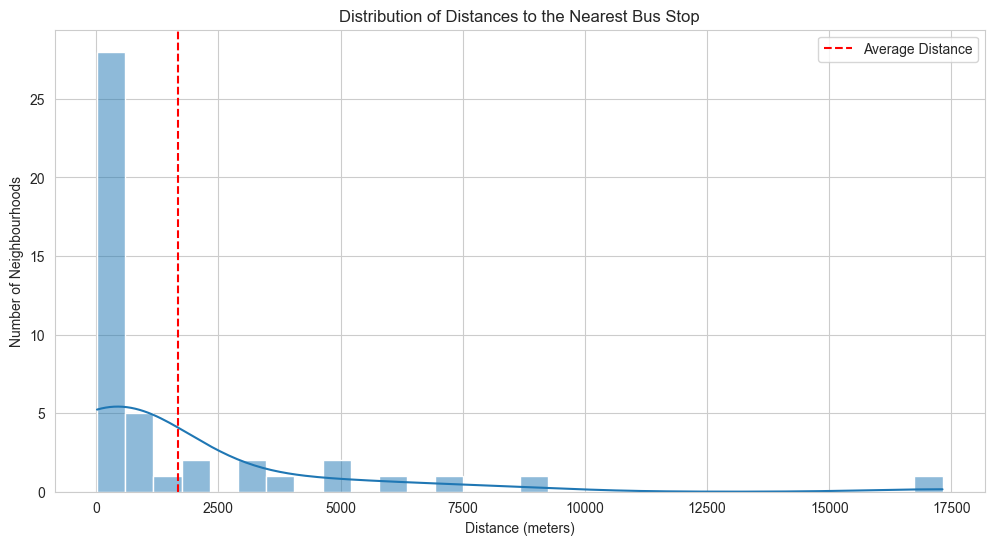

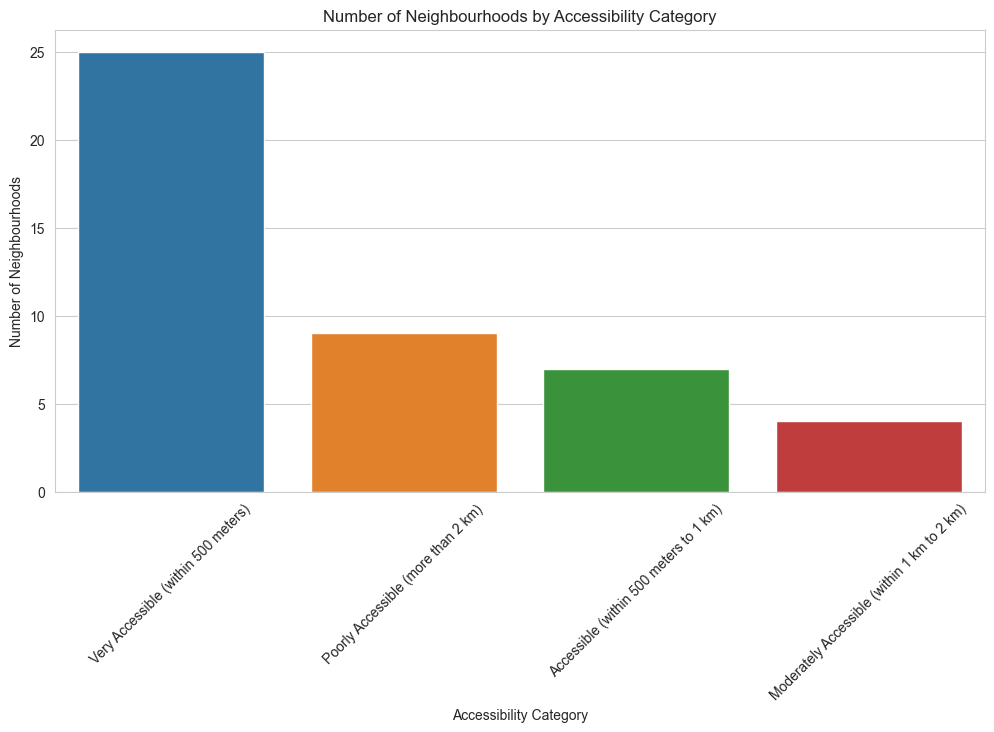

,mean,min,max,std
Accessibility_Category,,,,
Accessible (within 500 meters to 1 km),695.958535,506.734221,956.580247,186.952991
Moderately Accessible (within 1 km to 2 km),1520.774509,1037.624677,1776.923661,349.017656
Poorly Accessible (more than 2 km),6653.252849,3142.524679,17316.351445,4409.083156
Very Accessible (within 500 meters),184.551734,15.056346,493.493330,130.991176


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of distances to the nearest bus stop
plt.figure(figsize=(12, 6))
sns.histplot(neighbourhoods_df['Distance_to_Nearest_Stop'], bins=30, kde=True)
plt.title('Distribution of Distances to the Nearest Bus Stop')
plt.xlabel('Distance (meters)')
plt.ylabel('Number of Neighbourhoods')
plt.axvline(neighbourhoods_df['Distance_to_Nearest_Stop'].mean(), color='r', linestyle='--', label='Average Distance')
plt.legend()
plt.show()

# Bar plot of accessibility categories
plt.figure(figsize=(12, 6))
sns.countplot(data=neighbourhoods_df, x='Accessibility_Category', order=neighbourhoods_df['Accessibility_Category'].value_counts().index)
plt.title('Number of Neighbourhoods by Accessibility Category')
plt.xlabel('Accessibility Category')
plt.ylabel('Number of Neighbourhoods')
plt.xticks(rotation=45)
plt.show()

# Statistics for each category
category_stats = neighbourhoods_df.groupby('Accessibility_Category')['Distance_to_Nearest_Stop'].agg(['mean', 'min', 'max', 'std'])
category_stats


In [27]:
import folium

# Initialize the map centered at Kingston's coordinates
kingston_map = folium.Map(location=[44.2312, -76.4860], zoom_start=12)

# Plot each neighbourhood with color coding based on accessibility category
for _, row in neighbourhoods_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color='blue' if row['Accessibility_Category'] == 'Very Accessible (within 500 meters)' else
              'green' if row['Accessibility_Category'] == 'Accessible (within 500 meters to 1 km)' else
              'orange' if row['Accessibility_Category'] == 'Moderately Accessible (within 1 km to 2 km)' else
              'red',
        fill=True,
        fill_color='blue' if row['Accessibility_Category'] == 'Very Accessible (within 500 meters)' else
                    'green' if row['Accessibility_Category'] == 'Accessible (within 500 meters to 1 km)' else
                    'orange' if row['Accessibility_Category'] == 'Moderately Accessible (within 1 km to 2 km)' else
                    'red',
        fill_opacity=0.7,
        popup=row['NAME']
    ).add_to(kingston_map)

# Add bus stop locations as markers
for _, stop in transit_stops_df.iterrows():
    folium.Marker(
        location=[stop['Latitude'], stop['Longitude']],
        icon=folium.Icon(icon='bus', prefix='fa'),
        popup=stop['Name']
    ).add_to(kingston_map)

# Display the map
kingston_map


In [31]:
import plotly.graph_objects as go

# Initialize the map
fig = go.Figure()

# Add neighbourhoods to the map with different colors based on accessibility category
for category, color in zip(['Very Accessible (within 500 meters)', 'Accessible (within 500 meters to 1 km)', 'Moderately Accessible (within 1 km to 2 km)', 'Poorly Accessible (more than 2 km)'],
                           ['blue', 'green', 'orange', 'red']):
    df_filtered = neighbourhoods_df[neighbourhoods_df['Accessibility_Category'] == category]
    fig.add_trace(go.Scattermapbox(
        lat=df_filtered['Latitude'],
        lon=df_filtered['Longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color=color,
            opacity=0.7
        ),
        text=df_filtered['NAME'],
        hoverinfo='text',
        name=category
    ))

# Add bus stops to the map
fig.add_trace(go.Scattermapbox(
    lat=transit_stops_df['Latitude'],
    lon=transit_stops_df['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=7,
        color='yellow',
        opacity=0.9
    ),
    text=transit_stops_df['Name'],
    hoverinfo='text',
    name='Bus Stops'
))

# Set up the map layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=11,
    mapbox_center={"lat": 44.2312, "lon": -76.4860},
    margin={"r":0,"t":0,"l":0,"b":0}
)

# Show the map
fig.show()
